Copyright 2019-2021 Universidad Complutense de Madrid

This file software has been employed to reduce infrared raw data from the CIRCE camera at GTC

Authors: Cristina Cabello (criscabe@ucm.es), Nicolás Cardiel (cardiel@ucm.es) Jesús Gallego (j.gallego@ucm.es)

SPDX-License-Identifier: GPL-3.0+ License-Filename: LICENSE.txt

In [10]:
import numpy as np
import matplotlib.pyplot as plt

import math as m
import pandas as pd

from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
from astropy.nddata import NDData
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import LogStretch
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel
from astropy.modeling.models import Gaussian2D
from astropy.modeling import models, fitting
from astropy.stats import (gaussian_sigma_to_fwhm, gaussian_fwhm_to_sigma,
                           sigma_clipped_stats)

import photutils
from photutils.psf import extract_stars
from photutils import find_peaks
from photutils import EPSFBuilder
from photutils import (HanningWindow, TukeyWindow, CosineBellWindow,
                       SplitCosineBellWindow, TopHatWindow)
from photutils import CosineBellWindow, create_matching_kernel

from scipy.interpolate import UnivariateSpline
from scipy import optimize
from scipy.ndimage import convolve
from scipy.signal import convolve2d

from skimage.transform import rescale

In [11]:
# Functions to fit a 2D Gaussian to the 2D distribution of the data

def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-x)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-y)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

## <span style="color:red"> PSF OF THE NB1257/CIRCE IMAGE </span>


We are going to build the ePSF using bright isolated stars in the image, following the method described in https://photutils.readthedocs.io/en/stable/epsf.html#build-epsf 

First, we load the final NB1257 image obtained with the CIRCE instrument

In [12]:
with fits.open('CIRCE_image.fits', mode='readonly') as hdulist:
    image_data  = hdulist[0].data
    image_data  = image_data/300  # To have units of ADU/s

Then we identify the stars and their initial positions. We set the detection threshold value to 0.026 to select only the two brightest stars

In [13]:
peaks_tbl = find_peaks(image_data, threshold=0.026)  
peaks_tbl['peak_value'].info.format = '%.8g'    
print(peaks_tbl)  

x_peak y_peak  peak_value
------ ------ -----------
   760   1158 0.055952727
   280   1318   0.8095016


We extract 95 x 95 pixel cutouts of our selected stars using the extract_stars() function. This function requires the input data as an NDData object, so we transformed our data array into it. Moreover, the information of the stars must be in a table format, with their positions X and Y in pixels.
We use the sigma-clipped median value as the background level, and we subtract the background from the image.

In [14]:
size = 95
hsize = (size - 1) / 2
x = peaks_tbl['x_peak']  
y = peaks_tbl['y_peak']  
mask = ((x > hsize) & (x < (image_data.shape[1] -1 - hsize)) &
        (y > hsize) & (y < (image_data.shape[0] -1 - hsize)))  

stars_tbl = Table()
stars_tbl['x'] = x[mask]  
stars_tbl['y'] = y[mask]

mean_val, median_val, std_val = sigma_clipped_stats(image_data, sigma=2.)  
image_data -= median_val 


nddata = NDData(data=image_data) 
stars = extract_stars(nddata, stars_tbl, size=95)

The extract_stars() function returns a EPSFStars object containing the cutouts of our two selected stars from which we’ll build our ePSF. Let’s show them:

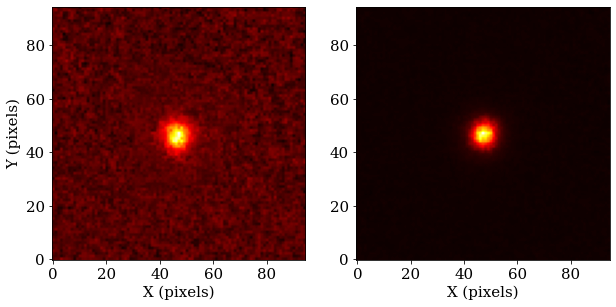

In [15]:
nrows = 1
ncols = 2

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10),
                       squeeze=True)
ax = ax.ravel()
plt.sca(ax[0])
plt.xlabel('X (pixels)', fontsize=15,family='serif')
plt.ylabel('Y (pixels)', fontsize=15,family='serif')
plt.yticks(fontname = 'serif', size=15)
plt.xticks(fontname = 'serif', size=15)
plt.sca(ax[1])
plt.xlabel('X (pixels)', fontsize=15,family='serif')
plt.ylabel('', fontsize=15,family='serif')
plt.yticks(fontname = 'serif', size=15)
plt.xticks(fontname = 'serif', size=15)
for i in range(nrows*ncols):
    ax[i].imshow(stars[i], origin='lower', cmap='hot')
plt.show()    
    
    


We use the EPSFBuilder class to create an ePSF with an oversampling factor of 2.0. 
We first initialize an EPSFBuilder instance with our desired parameters and then input the cutouts of our selected stars to the instance.

In [16]:
epsf_builder = EPSFBuilder( oversampling =2,maxiters=1,progress_bar=False)  
epsf, fitted_stars = epsf_builder(stars)  

The returned values are the ePSF, as an EPSFModel object, and our input stars fitted with the constructed ePSF, as a new EPSFStars object with fitted star positions and fluxes. We show the constructed ePSF:

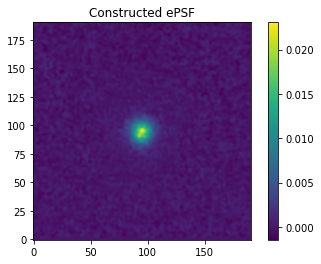

In [17]:
plt.imshow(epsf.data,origin='lower', cmap='viridis')
plt.colorbar()
plt.title('Constructed ePSF')
plt.show()

We correct the oversampling factor:

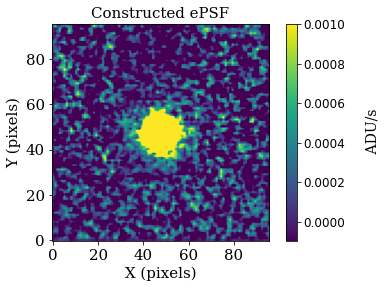

In [18]:
image_rescaled = rescale(epsf.data, 0.5)

cmap = plt.imshow(image_rescaled,origin='lower', cmap='viridis',vmin=-0.0001, vmax=0.001)
cb = plt.colorbar(cmap)
cb.ax.tick_params(labelsize=12)
cb.set_label('\n ADU/s', fontsize=14,family='serif')
plt.title('Constructed ePSF', fontsize=15,family='serif')
plt.xlabel('X (pixels)', fontsize=15,family='serif')
plt.ylabel('Y (pixels)', fontsize=15,family='serif')
plt.yticks(fontname = 'serif', size=15)
plt.xticks(fontname = 'serif', size=15)
plt.show()


We perform a 2D Gaussian fit to smooth the CIRCE ePSF

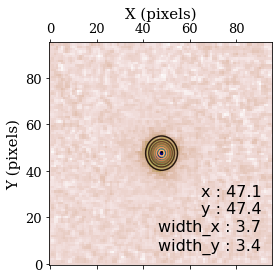

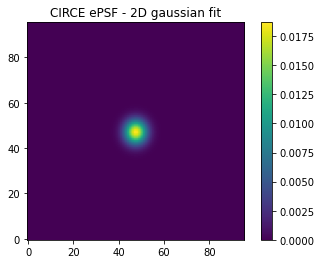

In [19]:
data = image_rescaled

plt.matshow(data,origin='lower', cmap=plt.cm.gist_earth_r)

params = fitgaussian(data)
fit = gaussian(*params)

plt.contour(fit(*np.indices(data.shape)), cmap=plt.cm.copper,origin='lower')
ax = plt.gca()
(height, x, y, width_x, width_y) = params

plt.text(0.95, 0.05, """
x : %.1f
y : %.1f
width_x : %.1f
width_y : %.1f""" %(x, y, width_x, width_y),
        fontsize=16, horizontalalignment='right',
        verticalalignment='bottom', transform=ax.transAxes)
ax.set_xlabel('X (pixels)', fontsize=15,family='serif')
ax.set_ylabel('Y (pixels)', fontsize=15,family='serif')
plt.yticks(fontname = 'serif', size=13)
plt.xticks(fontname = 'serif', size=13)
ax.xaxis.set_label_position('top') 
plt.show()


final_fit = fit(*np.indices(data.shape))


plt.imshow(final_fit,origin='lower', cmap='viridis')
plt.colorbar()
plt.title('CIRCE ePSF - 2D gaussian fit')
plt.show()

Saving the final image of the CIRCE PSF

In [20]:
CIRCE_ePSF = final_fit

hdu = fits.PrimaryHDU(final_fit)
hdul = fits.HDUList([hdu])
hdul.writeto('CIRCE_ePSF_2Dgauss_fit.fits', clobber=True)



## <span style="color:red"> PSF OF THE F125W/HST IMAGE </span>


We follow the same steps to build the PSF of the HST image

In [21]:
with fits.open('HST_image.fits', mode='readonly') as hdulist:
    image_data  = hdulist[0].data
    
image_HST = image_data    

In [22]:
peaks_tbl = find_peaks(image_data, threshold=35)  
peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output  
print(peaks_tbl) 

x_peak y_peak peak_value
------ ------ ----------
   480    797  62.795723
   758   1157   502.7471
   282   1315  4554.0122
  1002   1435  268.86838


In [23]:
size = 95
hsize = (size - 1) / 2
x = peaks_tbl['x_peak']  
y = peaks_tbl['y_peak']  
mask = ((x > hsize) & (x < (image_data.shape[1] -1 - hsize)) &
        (y > hsize) & (y < (image_data.shape[0] -1 - hsize)))  

stars_tbl = Table()
stars_tbl['x'] = x[mask]  
stars_tbl['y'] = y[mask]

mean_val, median_val, std_val = sigma_clipped_stats(image_data, sigma=2.)  
image_data -= median_val 


nddata = NDData(data=image_data) 
stars = extract_stars(nddata, stars_tbl, size=95)

/Users/criscabe/opt/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


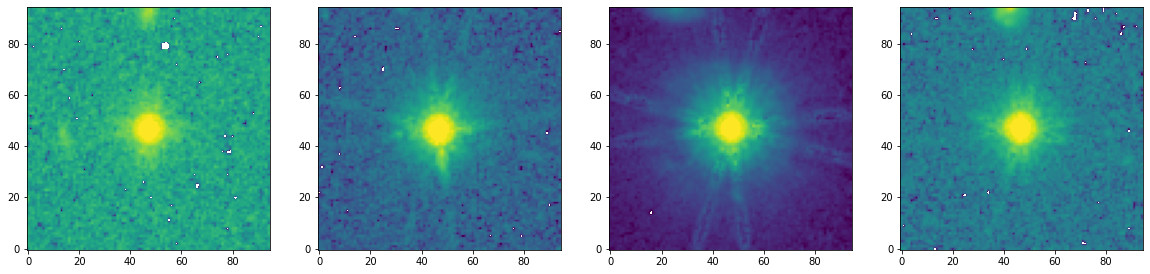

In [24]:
nrows = 1
ncols = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows*ncols):
    norm = simple_norm(stars[i], 'log', percent=99.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')
plt.show()



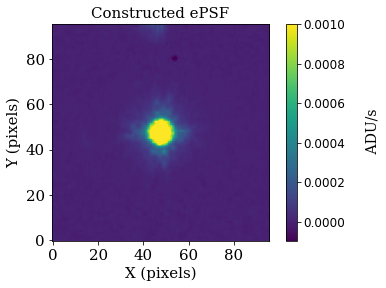

In [25]:
epsf_builder = EPSFBuilder(oversampling =2, maxiters=3,progress_bar=False)  
epsf, fitted_stars = epsf_builder(stars)  


image_rescaled = rescale(epsf.data, 0.5)


cmap = plt.imshow(image_rescaled,origin='lower', cmap='viridis',vmin=-0.0001, vmax=0.001)
cb = plt.colorbar(cmap)
cb.ax.tick_params(labelsize=12)
cb.set_label('\n ADU/s', fontsize=14,family='serif')
plt.title('Constructed ePSF', fontsize=15,family='serif')
plt.xlabel('X (pixels)', fontsize=15,family='serif')
plt.ylabel('Y (pixels)', fontsize=15,family='serif')
plt.yticks(fontname = 'serif', size=15)
plt.xticks(fontname = 'serif', size=15)
plt.show()

In [26]:
HST_ePSF = image_rescaled

hdu = fits.PrimaryHDU(image_rescaled)
hdul = fits.HDUList([hdu])
hdul.writeto('HST_ePSF.fits', clobber=True)

## <span style="color:red"> PSF MATCHING </span>


To achieve the PSF matching, we follow the procedure explained in https://photutils.readthedocs.io/en/stable/psf_matching.html

The PSFs of the CIRCE and the HST images have the same shape and pixel scale. Then, we create a matching kernel between the two PSFs using a Cosine Bell window. 

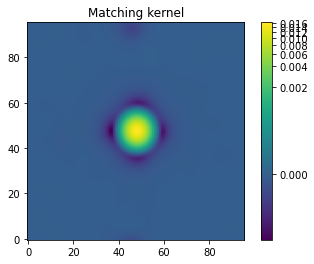

In [31]:
norm = ImageNormalize(stretch=LogStretch())

window = CosineBellWindow(alpha=3)


kernel = create_matching_kernel(HST_ePSF,CIRCE_ePSF, window=window)

plt.imshow(kernel, norm=norm, cmap='viridis', origin='lower')
plt.colorbar()
plt.title('Matching kernel')
plt.show()


Finally, we convolve the HST image with this matching kernel to degrade the HST image to the same spatial resolution as the CIRCE image. 

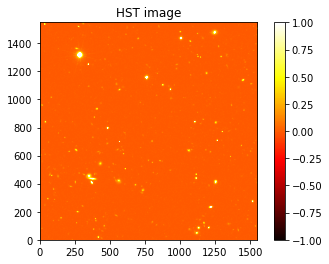

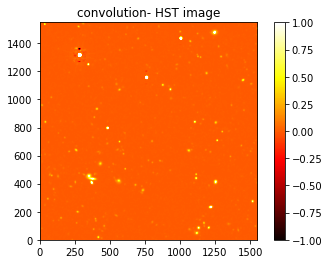

In [28]:
image_HST_conv = convolve(image_HST,kernel)


plt.imshow(image_HST, cmap='hot', origin='lower',vmin=-1, vmax=1)
plt.colorbar()
plt.title('HST image')
plt.show()

plt.imshow(image_HST_conv, cmap='hot', origin='lower',vmin=-1, vmax=1)
plt.colorbar()
plt.title('convolution- HST image')
plt.show()


In [29]:
hdu = fits.PrimaryHDU(image_HST_conv)
hdul = fits.HDUList([hdu])
hdul.writeto('HST_image_conv.fits', clobber=True)
